## Analyze A/B Test Exercise


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  

In this project I will go through the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.  
  

<a id='probability'></a>
#### Part I - Probability

First I will import the libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Reading in the `ab_data.csv` data. This will be stored in `df`.   
The first few lines of the dataset will be shown.

In [2]:
#The dataset is read and the first few rows are shown
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


The below cell is used to find the number of rows in the dataset.

In [3]:
#The number of rows in the dataset if found
df.shape[0]

294478

The number of unique users in the dataset.

In [4]:
#The amount of unique users are found
df['user_id'].nunique()

290584

The proportion of users converted.

In [5]:
#The amount of converted users is found
df.query('converted == 1').count()[0]/df.count()[0]

0

The number of times the `new_page` and `treatment` don't line up.

In [6]:
#A query is used to investigate when new_page and treatment does not line up
df.query("group == 'treatment' and landing_page == 'old_page'").count()[0] + df.query("group == 'control' and landing_page == 'new_page'").count()[0]


3893

Do any of the rows have missing values?

In [7]:
#Investigating if any of the rows have missing values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, it is not certain if this row truly received the new or old page.  

a. Removing values that are not adhering to expected values and store the new dataframe in **df2**.

In [8]:
#Removing data that is not adhering to the expected values
df2 = df.query("group == 'treatment' and landing_page == 'new_page' or group == 'control' and landing_page == 'old_page'")
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Using **df2** and the cells below to answer the posed questions

a. How many unique **user_id**s are in **df2**?

In [10]:
#The amount of unique user id's is investigated
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
#The single duplicate is shown
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [12]:
#See above

d. Remove **one** of the rows with a duplicate **user_id**, but keep the dataframe as **df2**.

In [13]:
#Removing one of the identified duplicate rows
df2 = df2.drop(1899)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


`4.` Use **df2** in the below cells to answer the posed questions.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
#Conversion rate
df2.query('converted == 1').count()[0]/df2.count()[0]

0

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
#Conversion rate for the control group, where the mean can be used as the conversion rate
df2.groupby('group').describe()

user_id                                                    \
              count           mean           std       min        25%   
group                                                                   
control    145274.0  788164.072594  91287.914601  630002.0  709279.50   
treatment  145310.0  787845.719290  91161.564429  630000.0  708745.75   

                                         converted                           \
                50%        75%       max     count      mean       std  min   
group                                                                         
control    788128.5  867208.25  945998.0  145274.0  0.120386  0.325414  0.0   
treatment  787876.0  866718.75  945999.0  145310.0  0.118808  0.323564  0.0   

                               
           25%  50%  75%  max  
group                          
control    0.0  0.0  0.0  1.0  
treatment  0.0  0.0  0.0  1.0

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
#See mean value above

d. What is the probability that an individual received the new page?

In [17]:
#Probability of any individual receiving the new page
df2.query('landing_page == "new_page"').count()[0]/df2.count()[0]

0

e. Use the results in the previous two portions of this question to suggest if there is evidence that one page leads to more conversions?  

The probability of converting is almost the same for the two pages. Out of a population of 290584 persons, the two conversion groups are just 450 persons apart. This is just 0.2% in difference which is not a significant difference. From the investigated dataset there is no clear evidence that one page leads to more conversions.
Of course boostrapping could be taken to use, but this will be done in the next section.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, I could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is, should I stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long should I run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now the decision will be based on all the data available.  Assuming that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what is the null and alternative hypotheses then?  

$H_0 = p_{new} \leq p_{old}$   
$H_1 = p_{new} > p_{old}$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

A  sample size equal to the ones in **ab_data.csv** will be used for each page.  <br><br>

A sampling distribution will be performed for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **convert rate** for $p_{new}$ under the null?   
b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [18]:
#The conversion rate for the new
p_new_real = df2.query('landing_page == "new_page"')['converted'].mean()
p_new = df2.query('converted == 1').count()[0]/df2.count()[0]
p_new

0

In [19]:
#The conversion rate for the old
p_old_real = df2.query('landing_page == "old_page"')['converted'].mean()
p_old = df2.query('converted == 1').count()[0]/df2.count()[0]
p_old

0

In [20]:
#Computing the difference between the real observed conversion rates
p_diff_real = p_new_real-p_old_real
p_diff_real

-0.0015782389853555567

c. What is $n_{new}$?

In [21]:
#The amount of users for the treatment group
n_new = df2.query('group == "treatment"').count()[0]
n_new

145310

d. What is $n_{old}$?

In [22]:
#The amount of users for the control group
n_old = df2.query('group == "control"').count()[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
#Simulating the amount of conversions given the amount of users and the possibility of conversion
new_page_converted = np.random.choice([0,1], size=n_new, replace=True, p=[1-p_new,p_new])
np.bincount(new_page_converted)

array([145310])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
#Simulating the amount of conversions given the amount of users and the possibility of conversion
old_page_converted = np.random.choice([0,1], n_old, replace=True, p=[1-p_old,p_old])
np.bincount(old_page_converted)

array([145274])

g. Find $p_{new}$ - $p_{old}$ for the simulated values from part (e) and (f).

In [25]:
#The difference in the simulated values is found
obs_diff = np.mean(new_page_converted)-np.mean(old_page_converted) 
obs_diff

0.0

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to parts **a. through g.**. All 10,000 values will be stored in **p_diffs**.

In [26]:
#10,000 simulations are run
p_diffs = []
for _ in range(10000):
    new_p2 = np.random.choice([0,1], size=n_new,replace=True, p=[1-p_new,p_new])
    old_p2 = np.random.choice([0,1], n_old, replace=True, p=[1-p_old,p_old])
    p_diffs.append(np.mean(new_p2) - np.mean(old_p2))
p_diffs = np.array(p_diffs)


i. A histogram of the **p_diffs** will be plotted.

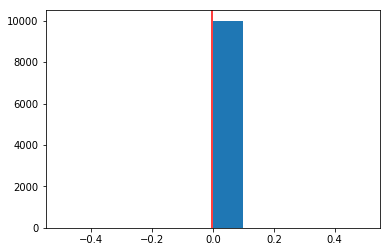

In [27]:
plt.hist(p_diffs);
plt.axvline(x=p_diff_real, color='red'); 

The red line is the difference between the $p_{new}$ - $p_{old}$ values, which is very close to zero.   
The blue distribution is the 10,000 simulated cases, showing the expected standard distribution when considering the Central Limit Theorem. 

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
#Finding the mean of the simulated datapoints that are higher than the observed difference in ab_data.csv 
(p_diffs > p_diff_real).mean()


1.0

k. What was just computed in part **j.**?.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

This is the p-value. The P-value shows that 90% of the simulated conversions are above the real difference observed. As the p-value is much larger than the used Type I error rate $\alpha$ = 0.05, then we fail to reject the $H_0$ hypothesis.

l. There exists a built-in function to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Below, the number of conversions for each page is calculated, as well as the number of individuals who received each page. Here `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm
#Finding the number of conversions for each page 
convert_old = df2.query('group == "control" and converted == 1').count()[0]
convert_new = df2.query('group == "treatment" and converted == 1').count()[0]
convert_old, convert_new, n_old, n_new  

(17489, 17264, 145274, 145310)

m. Now using the `stats.proportions_ztest` to compute the test statistic and p-value. 

In [30]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new],alternative = 'smaller')
#The z-score, p-value and the significance of the z-score is computed.  
z_score, p_value, norm.cdf(z_score)

(1.3109241984234394, 0.9050583127590245, 0.9050583127590245)

In [31]:
#The critical level for a Type I error of 5% for a one-sided z-test
norm.ppf(1-(0.05))

1.6448536269514722

n. What do the z-score and p-value computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The significance of the z-score is 0.91, which is below the critical level for a one-sided test at 1.65 for a Type I error $\alpha$ = 5%. Again, we fail to reject the $H_0$ hypothesis, which agrees with the findings in part j and k.  
The P-value is the same as was found in part j.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, it is shown that the result achieved in the previous A/B test can also be achieved by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should be performed?

Since the dataset is binary, a logistic regression will be used

b. The goal is to use **statsmodels** to fit the regression model specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, first create a column for the intercept, and create a dummy variable column for which page each user received.  A **intercept** column, as well as an **ab_page** column will be added, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:
df2['intercept'] = 1
# Column which is 1 when an individual receives the treatment and 0 if control
df2[['control','ab_page']] = pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


c. Use **statsmodels** to import the regression model.  Instantiate the model, and fit the model using the two columns created in part **b.** to predict whether or not an individual converts.

In [33]:
#The logit model is fitted
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])  
results = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [34]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 20 Jan 2020   Pseudo R-squ.:               8.077e-06
Time:                        14:01:31   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>

The investigated hypotheses are:  
$H_0 = p_{new} - p_{old} \leq 0$  
$H_1 = p_{new} - p_{old} > 0$  
The P-value is 0.190 and since it is greater than the Type I error $\alpha$ = 0.05 then we again fail to reject the null hypothesis. Again, it is recommended to keep the old page.  
In Part II I tested using a one-sided z-test and in this regression a two-sided test has been used hence explaining the difference in P-values

f. Now, considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into the regression model.  Are there any disadvantages to adding additional terms into the regression model?

**Answer**  
Other factors than provided in this dataset could influence this A/B test. The actual interesting parameters will always depend on the investigated case.
When adding other parameters to the model you should be aware of potentially introducing multicollinearity, as the parameters could be depending on each other and then influence the results.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. 
Does it appear that country had an impact on conversion? 

In [41]:
#The country dataset is read and joined with the existing dataset
df3 = pd.read_csv('countries.csv')
df3.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [42]:
# Maerge two files
df4 = df3.set_index('user_id').join(df2.set_index('user_id'))
df4.head()

,country,timestamp,group,landing_page,converted,intercept,control,ab_page
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


In [36]:
#Different countries in the dataset
df4['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [37]:
#Getting dummies
df4[['CA','UK','US']] = pd.get_dummies(df4['country'])
df4.head()

,country,timestamp,group,landing_page,converted,intercept,control,ab_page,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0


In [38]:
#The logit model is fitted to the data
lm = sm.Logit(df4['converted'],df4[['intercept','UK','US']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 20 Jan 2020   Pseudo R-squ.:               1.521e-05
Time:                        14:01:32   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

The countries have a P-value above the Type I error rate, which indicates that they do not have a significant influence on the conversion. We still fail to reject the null hypothesis.

h. Though after looking at the individual factors of country and page on conversion, now it is time to look at an interaction between page and country to see if there are significant effects on conversion. 

In [39]:
df4[['new','old']] = pd.get_dummies(df4['landing_page'])
df4.head()

,country,timestamp,group,landing_page,converted,intercept,control,ab_page,CA,UK,US,new,old
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0,1,0


In [40]:
lm = sm.Logit(df4['converted'],df4[['intercept','new','UK','US']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 20 Jan 2020   Pseudo R-squ.:               2.323e-05
Time:                        14:01:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
new           -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

No significant effects are seen on the conversion and we still fail to reject the null hypothesis.